In [6]:
from math import isnan
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# функция для расчета тройного интерквартильного размаха
def inq(col):
    return df[col].quantile(.75) + (df[col].quantile(.75) - df[col].quantile(.25)) * 3

In [8]:
df = pd.read_csv('ecom_raw.csv', sep=',', decimal=".")
df.columns = [x.lower().replace(" ", "_") for x in df.columns]
df.head()

,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN


# Устранение пропусков по данным


Строки с пропусками составляют 1.28%


<Axes: >

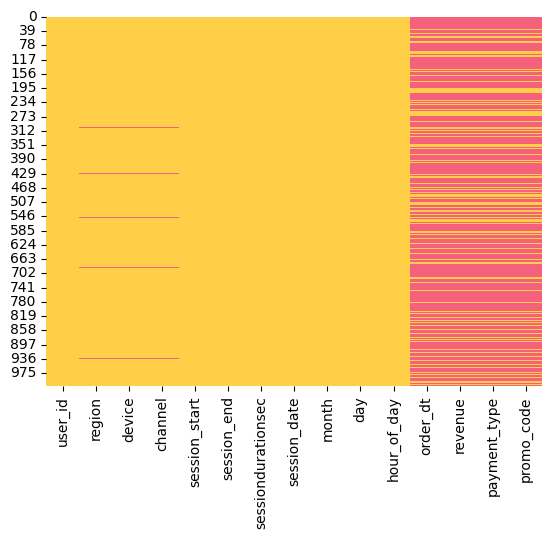

In [9]:
colours = ['#FFCF48', '#F5617D']
print(f'Строки с пропусками составляют {round(df["channel"].isna().value_counts()[True] / len(df["channel"]) * 100, 2)}%')
sns.heatmap(df.isna(), cmap=sns.color_palette(colours), cbar=False)

Eсть пропуски в категориальных данных, пропущен регион, устройство и тип канала.\
После поиска по индексу в пропусках было обнаружено, что некоторые индексы совпадают с теми, которые ранее были найдены в датасете.\
Было принято решение подставить эти категориальные данные, а те строки, id которых ранее не встречался или в нем тоже отсутствуют категориальные данные, было принято решение удалить

<Axes: >

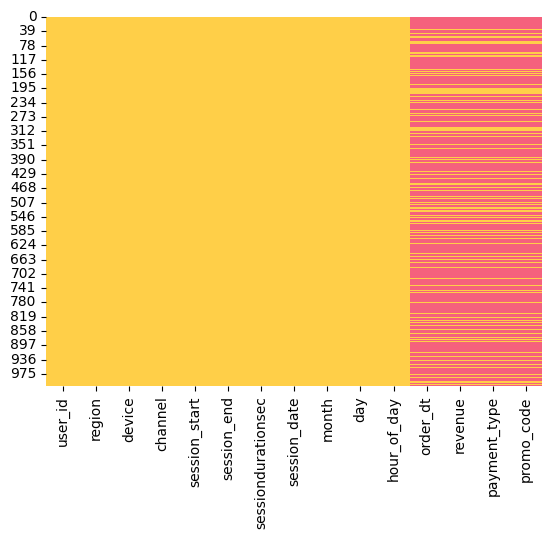

In [10]:
df1 = pd.DataFrame(df[df["region"].isnull()]["user_id"])
values = pd.DataFrame(df["user_id"].value_counts())
for uid in df1["user_id"]:
    if values.loc[uid, "count"] == 2:
        line2 = df.loc[df["user_id"] == uid].iloc[0]
        df.loc[df["user_id"] == uid, "device"] = line2["device"]
        df.loc[df["user_id"] == uid, "region"] = line2["region"]
        df.loc[df["user_id"] == uid, "channel"] = line2["channel"]
df = df.dropna(how="any", subset=["channel", "region"])
df = df.reset_index(drop=True)
sns.heatmap(df.isna(), cmap=sns.color_palette(colours), cbar=False)

In [11]:
# Столбец “payer” с информацией о том, является ли пользователь платящим или нет
df["payer"] = df["revenue"].apply(lambda x: int(not isnan(x)))
# Округление длительности сессии (так как все числа очень близки к целому, вероятно ошибка в процессе передачи)
df["sessiondurationsec"] = df["sessiondurationsec"].apply(round)

In [12]:
# Устранение явных дубликатов
if len(df["user_id"]) != len(list(set(df["user_id"]))):
    df = df.drop_duplicates(subset=["user_id"], ignore_index=True)
# Устранение ошибок в категориальных данных
df.loc[df["channel"] == "контексная реклама", "channel"] = "контекстная реклама"
df.loc[df["device"] == "android", "device"] = "Android"
df.loc[df["region"] == "Unjted States", "region"] = "United States"
df.loc[df["region"] == "germany", "region"] = "Germany"
df.loc[df["region"] == "Franсe", "region"] = "France"
df.loc[df["region"] == "Frаnce", "region"] = "France"
df.loc[df["region"] == "Frаncе", "region"] = "France"
df.loc[df["region"] == "UК", "region"] = "UK"

In [13]:
# Преобразование данных с временными значениями
df["session_start"] = pd.to_datetime(df["session_start"])
df["session_end"] = pd.to_datetime(df["session_end"])
df["session_date"] = pd.to_datetime(df["session_date"])
df["order_dt"] = pd.to_datetime(df["order_dt"])

In [14]:
# Проверка на ошибки в данных с временем
for index, row in df.iterrows():
    row_has_mistake = 0
    if row["session_start"] > row["session_end"] or row["sessiondurationsec"] < 0 :
        row_has_mistake = 1
    if row["session_date"].date() != row["session_start"].date():
        row_has_mistake = 1
    if row["month"] != row["session_date"].month or row["day"] != row["session_date"].day_of_week + 1:
        row_has_mistake = 1
    if row_has_mistake:
        print("Обнаружена ошибка в данных")

Исследуемый период с 2019-10-31 по 2019-05-01 продолжительностью 183 дня


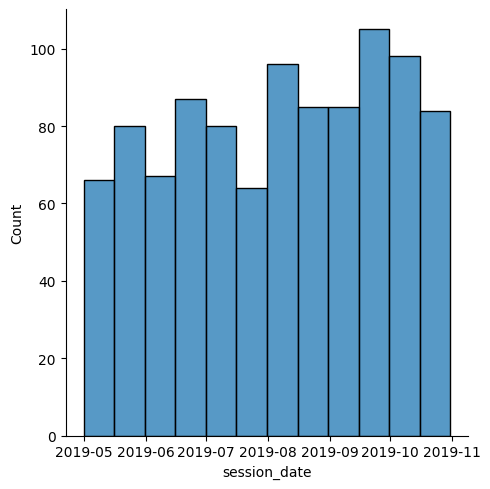

In [15]:
# Период исследования
print(f'Исследуемый период с {max(df["session_date"]).date()} по {min(df["session_date"]).date()} продолжительностью'
      f' {(max(df["session_date"]) - min(df["session_date"])).days} дня')
sns.displot(df["session_date"], bins=12)

После построения гистограммы по месяцам видно, что количество записей распределены про месяцам ненормально, но при этом нет выбросов, поэтому стоит учитывать весь период.

<Axes: ylabel='sessiondurationsec'>

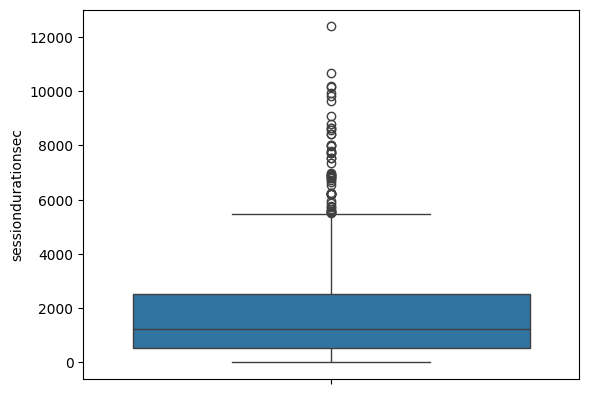

In [16]:
sns.boxplot(df["sessiondurationsec"])

<Axes: ylabel='revenue'>

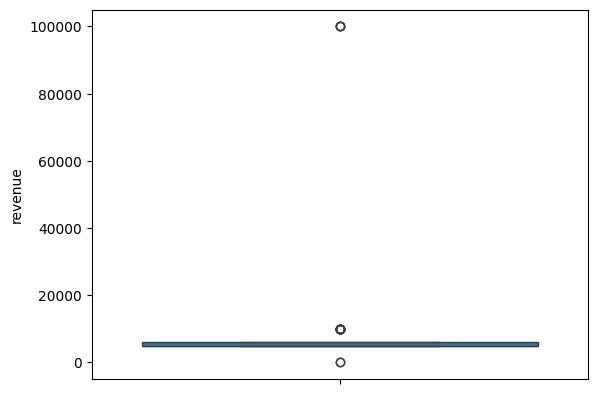

In [17]:
sns.boxplot(df["revenue"])

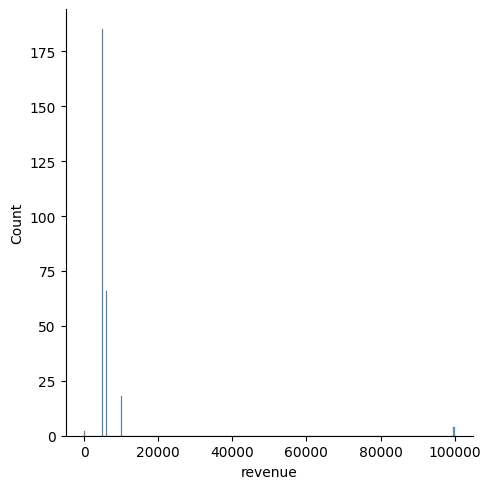

In [18]:
sns.displot(df.loc[df["payer"] == 1, "revenue"])

Есть выбросы в большую сторону в длительности сессиии и доходе.\
Принято решение устранить их методом тройного интерквартильного размаха.\
Значения выбросов заменены медианой по группе канала рекламы и по региону.

In [19]:
# Устранение выбросов
channels = list(set(df["channel"]))
regions = list(set(df["region"]))
sigma_revenue = round(df.loc[df["payer"] == 1, "revenue"].std())
mean_revenue = round(df.loc[df["payer"] == 1, "revenue"].mean())
for channel_type in channels:
    for region in regions:
        median_sessionduration = df.loc[(df["channel"] == channel_type) & (df["region"] == region), "sessiondurationsec"].median()
        if isnan(median_sessionduration):
            median_sessionduration = df.loc[(df["channel"] == channel_type), "sessiondurationsec"].median()
        df.loc[(df["channel"] == channel_type) & (df["region"] == region) &
               (df["sessiondurationsec"] > inq("sessiondurationsec")), "sessiondurationsec"] = int(median_sessionduration)

        median_revenue = df.loc[(df["channel"] == channel_type) & (df["region"] == region) & (df["payer"] == 1), "revenue"].median()
        if isnan(median_revenue):
            median_revenue = df.loc[(df["channel"] == channel_type) & (df["payer"] == 1), "revenue"].median()
        if median_revenue == 5499:
            median_revenue = 4999
        df.loc[(df["channel"] == channel_type) & (df["region"] == region) & (
                df["revenue"] > mean_revenue + sigma_revenue) & (df["payer"] == 1), "revenue"] = int(median_revenue)
        df.loc[(df["channel"] == channel_type) & (df["region"] == region) & (
                    df["revenue"] < abs(mean_revenue - sigma_revenue)) & (df["payer"] == 1), "revenue"] = int(median_revenue)

Для дохода было принято решение использовать правило сигмы, так как интерквартильный размах отсекал данные, которые не показались команде выбросами

In [20]:
# функция для добавления нового столбца в зависимости от времени суток визита
def sort_by_time_of_day(time):
    time = time.hour
    if 10 > time >= 6:
        return "утро"
    if 17 > time >= 10:
        return "день"
    if 22 > time >= 17:
        return "вечер"
    if time >= 22 or time < 6:
        return "ночь"


# Добавление столбца "time_of_day" в зависимости от времени суток
df["time_of_day"] = df["session_start"].apply(sort_by_time_of_day)

In [21]:
# Добавление столбца "promo_code" с итоговой суммой покупки после промокода 10%
df["final_price"] = df["revenue"]
df.loc[df["promo_code"] == 1, "final_price"] = df.loc[df["promo_code"] == 1, "final_price"].apply(lambda x: round(x * 0.9))

Text(0.5, 0.98, 'Доля продаж по регионам')

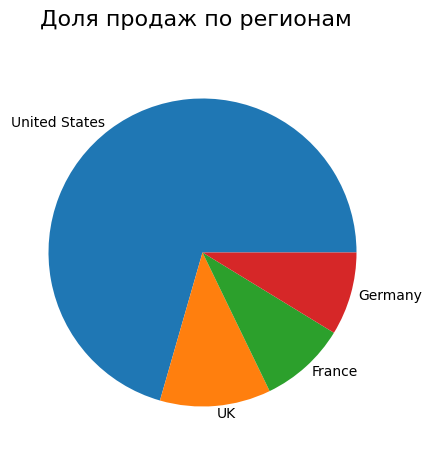

In [22]:
y = df.loc[df["payer"] == 1, "region"].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(y, labels=y.index, labeldistance=1.05)
plt.suptitle("Доля продаж по регионам", size=16)

Text(0.5, 0.98, 'Доля продаж по источникам')

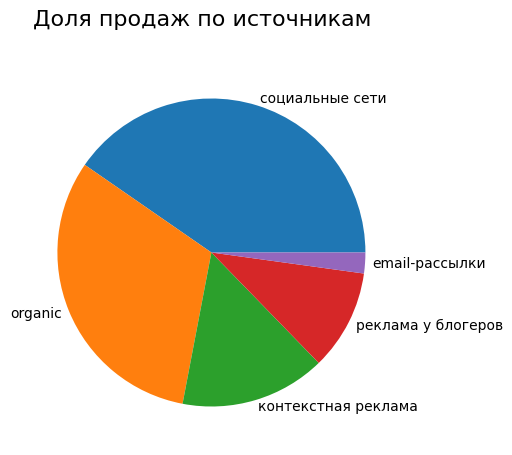

In [23]:
y = df.loc[df["payer"] == 1, "channel"].value_counts()
plt.figure(figsize=(7, 5))
plt.pie(y, labels=y.index, labeldistance=1.05)
plt.suptitle("Доля продаж по источникам", size=16)

Text(0.5, 0.98, 'Доля продаж по устройствам')

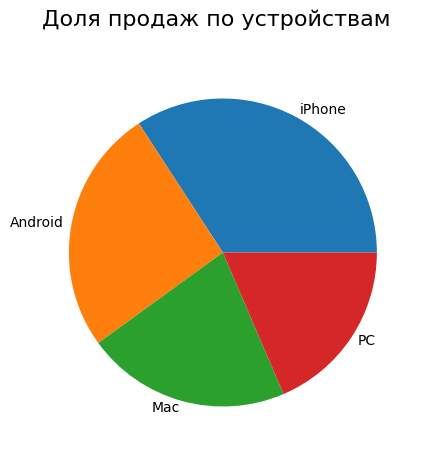

In [24]:
y = df.loc[df["payer"] == 1, "device"].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(y, labels=y.index, labeldistance=1.05)
plt.suptitle("Доля продаж по устройствам", size=16)

Text(0.5, 0.98, 'Сезонность по дням недели')

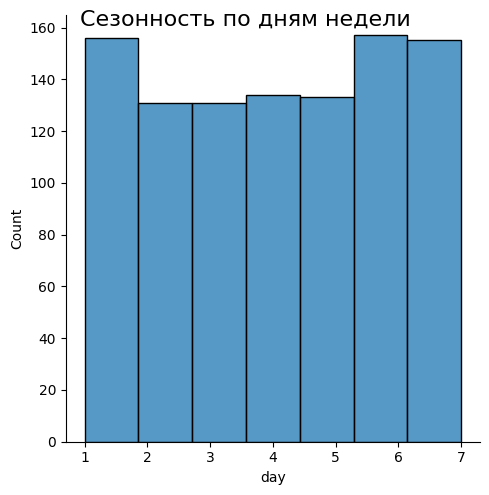

In [25]:
sns.displot(df["day"], bins=7)
plt.suptitle("Сезонность по дням недели", size=16)

Text(0.5, 0.98, 'Сезонность по месяцам')

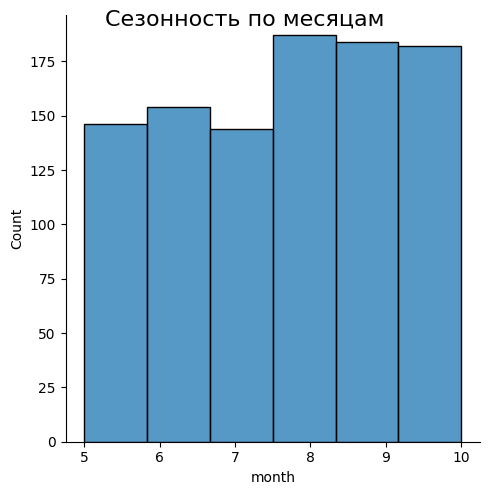

In [26]:
sns.displot(df["month"], bins=6)
plt.suptitle("Сезонность по месяцам", size=16)

Text(0.5, 0.98, 'Сезонность по времени дня')

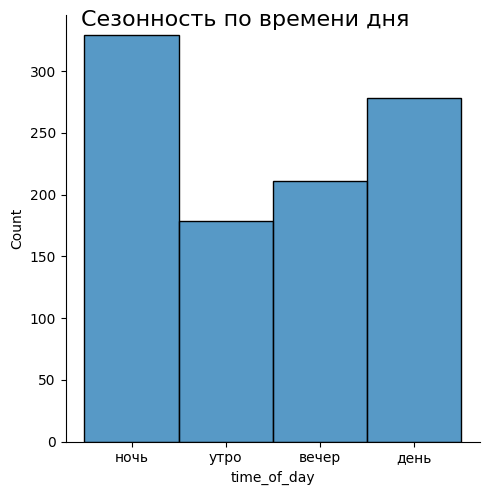

In [27]:
sns.displot(df["time_of_day"], bins=4)
plt.suptitle("Сезонность по времени дня", size=16)

Text(0.5, 0.98, 'Количество посетителей по регионам')

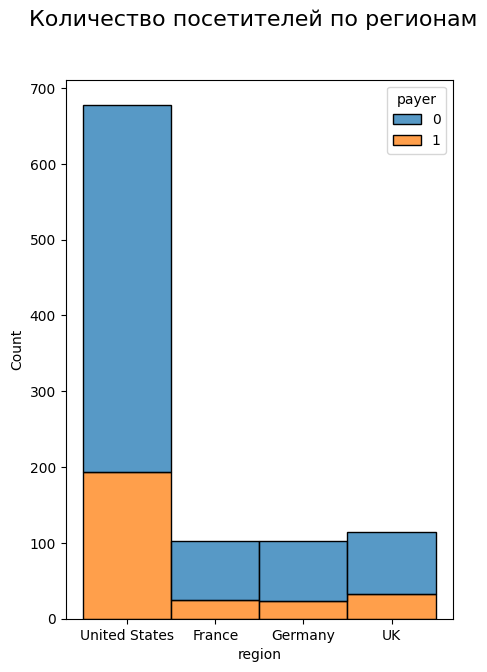

In [28]:
plt.figure(figsize=(5, 7))
sns.histplot(df, x="region", hue="payer", stat="count", multiple="stack")
plt.suptitle("Количество посетителей по регионам", size=16)

Text(0.5, 0.98, 'Количество посетителей по устройствам')

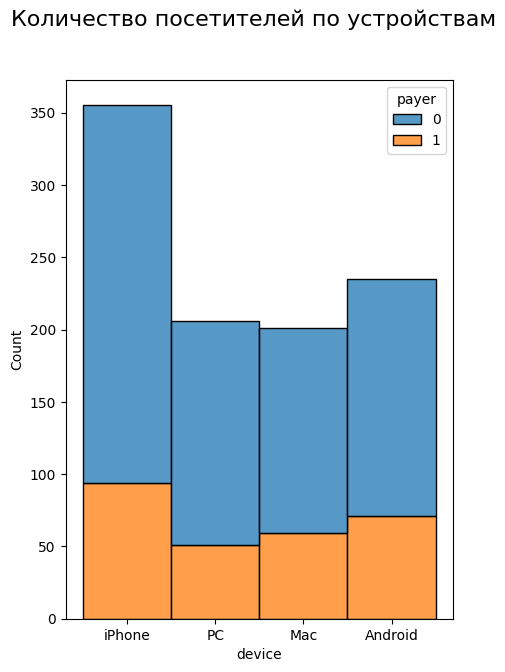

In [29]:
plt.figure(figsize=(5, 7))
sns.histplot(df, x="device", hue="payer", stat="count", multiple="stack")
plt.suptitle("Количество посетителей по устройствам", size=16)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'социальные сети'),
  Text(1, 0, 'organic'),
  Text(2, 0, 'реклама у блогеров'),
  Text(3, 0, 'контекстная реклама'),
  Text(4, 0, 'email-рассылки')])

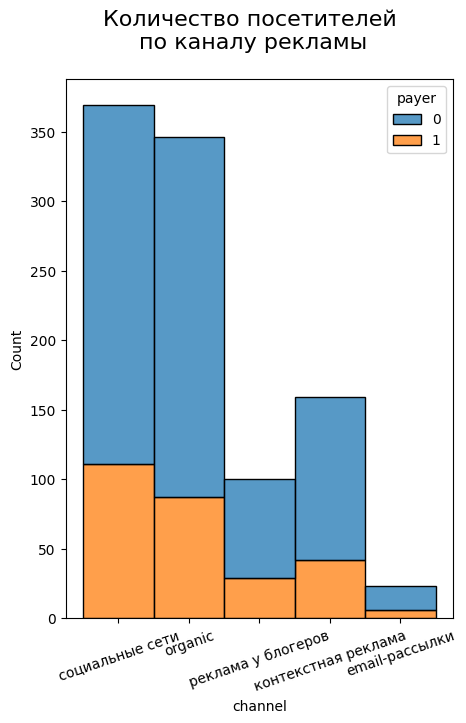

In [30]:
# По каналу рекламы
plt.figure(figsize=(5, 7))
sns.histplot(df, x="channel", hue="payer", stat="count", multiple="stack", cbar=False)
plt.suptitle("Количество посетителей \nпо каналу рекламы", size=16)
plt.xticks(rotation=19)

Text(0.5, 0.98, 'Количество покупок по типу оплаты')

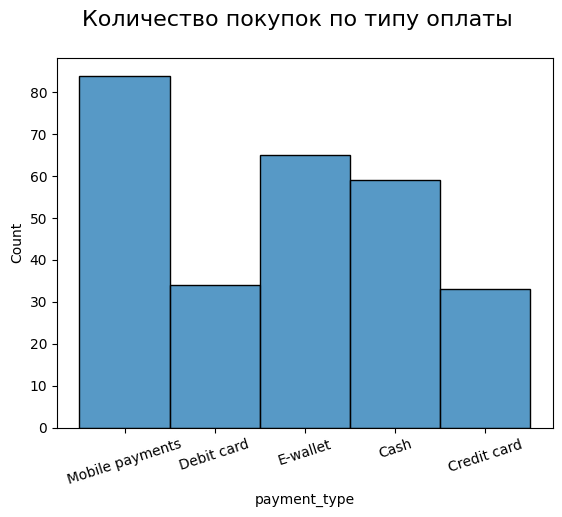

In [31]:
# Диаграмма количества покупок по типу оплаты
sns.histplot(df, x="payment_type", stat="count")
plt.xticks(rotation=18)
plt.suptitle("Количество покупок по типу оплаты", size=16)

In [32]:
df.to_csv(r"ecom_processed.csv")